In [287]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
import pathlib
import shutil
import cv2
import os
import json
from PIL import Image

from engine import train_one_epoch, evaluate
import utils

import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [471]:
class SugarcaneWeedsDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transforms=None):
        super().__init__()
        
        self.img_ids = list(sorted(os.listdir(os.path.join(root, "jpg_images_allweeds"))))
        self.img_dir = pathlib.Path(data_dir) / "jpg_images_allweeds"
        with open(os.path.join(data_dir, "weed_labels.json")) as f:
            self.annot = json.load(f)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        img = Image.open(self.img_dir/img_id).convert('RGB')
        
        box_dict = self.annot[img_id]['regions']
        obj_classes = [x['region_attributes']['label'] for x in box_dict]
        num_classes = len(set(obj_classes))
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_classes)
        boxes = []
        for i in range(num_objs):
            if obj_classes[i] == 'weed':  # Weed class only for now
                bd   = box_dict[i]['shape_attributes']
                xmin = bd['x']
                xmax = bd['x'] + bd['width']
                ymin = bd['y']
                ymax = bd['y'] + bd['height']
                boxes.append([xmin, ymin, xmax, ymax])
                
        # convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # instance labels
        labels = torch.ones((num_objs,), dtype=torch.int64)
#         labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_id'] = torch.tensor([idx])
#         target['filename'] = img_id
#         target['raw_annot'] = annotations
        
        # resize image and target boxes
        new_size = 1024
        sm_side = min(img.size)
        scale = new_size/sm_side
        resize_t = T.Resize(size=new_size)  # resizes smallest side to size
        img = resize_t(img)
        target['boxes'] = scale*target['boxes']
    
        # Apply other transforms. Note - these may not reshape/rescale/flip the underlying image
        #   because bounding boxes are not changed
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    def __len__(self):
        return len(self.img_ids)
    

In [472]:
def get_transform(train):
    
    transforms = [
        
    ]
    
    transforms.append(T.ToTensor())
    if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
        pass
    return T.Compose(transforms)

In [473]:
# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [474]:
# ## Test out forward() method
# data_dir = '/Users/mschoder/weeding_project/box_labeled_data'

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = SugarcaneWeedsDataset(data_dir, get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=4,
#  collate_fn = utils.collate_fn)

# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions


In [475]:
def get_model_fastrcnn_base(num_classes):
    
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [476]:
# Get DataLoaders

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: ", device)

# TODO - our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = SugarcaneWeedsDataset(data_dir, get_transform(train=True))
dataset_test = SugarcaneWeedsDataset(data_dir, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
num_imgs_test = int(len(dataset) * 0.3)
dataset = torch.utils.data.Subset(dataset, indices[:-num_imgs_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[num_imgs_test:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


Device:  cpu


In [478]:
# Get a batch of training data
inputs, targets = next(iter(data_loader))

In [479]:
def plot_batch_labels(inputs, targets):
    
    tensor2img = T.ToPILImage()
    n_images = len(inputs)
#     fig,ax = plt.subplots(1,n_images)
    fig = plt.figure(figsize=(16., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, n_images),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    
    for ax, img, tgt in zip(grid, inputs, targets):
        img = tensor2img(img)
        ax.imshow(img)
        ax.set_title(str(tgt['img_id'].numpy()) + " " + str(img.size) + "  " + str(tgt['labels'].numpy()))
        for box in tgt['boxes'].numpy():
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            


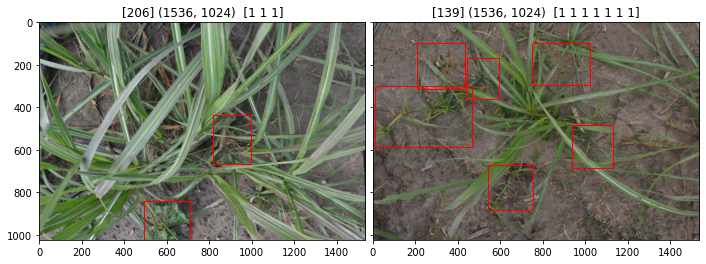

In [480]:
# Plot example batch
plot_batch_labels(inputs, targets)

In [481]:
targets[0]

{'boxes': tensor([[ 815.3334,  435.3333,  994.3334,  664.6667],
         [ 490.6667,  840.3334,  708.6667, 1022.3334]]),
 'labels': tensor([1, 1, 1]),
 'img_id': tensor([206])}

In [482]:
# def vis_detections(im, class_name, dets, thresh=0.5):
#     """Draw detected bounding boxes."""
#     inds = np.where(dets[:, -1] >= thresh)[0]
#     if len(inds) == 0:
#         return

#     im = im[:, :, (2, 1, 0)]
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.imshow(im, aspect='equal')
#     for i in inds:
#         bbox = dets[i, :4]
#         score = dets[i, -1]

#         ax.add_patch(
#             plt.Rectangle((bbox[0], bbox[1]),
#                           bbox[2] - bbox[0],
#                           bbox[3] - bbox[1],
#                           fill=False,
#                           edgecolor='red',
#                           linewidth=3.5))
#         ax.text(
#             bbox[0],
#             bbox[1] - 2,
#             '{:s} {:.3f}'.format(class_name, score),
#             bbox=dict(facecolor='blue', alpha=0.5),
#             fontsize=14,
#             color='white')

#     ax.set_title(
#         ('{} detections with '
#          'p({} | box) >= {:.1f}').format(class_name, class_name, thresh),
#         fontsize=14)
#     plt.axis('off')
#     plt.tight_layout()
#     plt.draw()
    

In [483]:
# TODO - fix - get the model using our helper function
model = get_model_fastrcnn_base(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/100]  eta: 0:57:28  lr: 0.000055  loss: 1.0180 (1.0180)  loss_classifier: 0.7131 (0.7131)  loss_box_reg: 0.1324 (0.1324)  loss_objectness: 0.1343 (0.1343)  loss_rpn_box_reg: 0.0382 (0.0382)  time: 34.4835  data: 0.9116


KeyboardInterrupt: 